<a href="https://colab.research.google.com/github/HamzaBTW/WeatherPredictor/blob/main/SMS_Classification_(By_Hamza_Sajid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import important modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation
import nltk
nltk.download('stopwords')


# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score)
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# text preprocessing modules
from nltk.tokenize import word_tokenize

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re #regular expression


from wordcloud import WordCloud, STOPWORDS

# Download dependency
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)


import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [3]:
# load data
data = pd.read_csv("spam.tsv", sep="\t")

In [4]:
# show top five rows
data.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [5]:
# check missing values
data.isnull().sum()

,0
label,0
message,0
length,0
punct,0


In [6]:
# check the shape
data.shape

(5572, 4)

In [7]:
# explore ham labeled sms
def collect_words(data, label):
    collected_words = " "

    # iterate through the csv file
    for val in data.message[data["label"] == label]:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        for words in tokens:
            collected_words = collected_words + words + " "

    return collected_words

Total words 349132


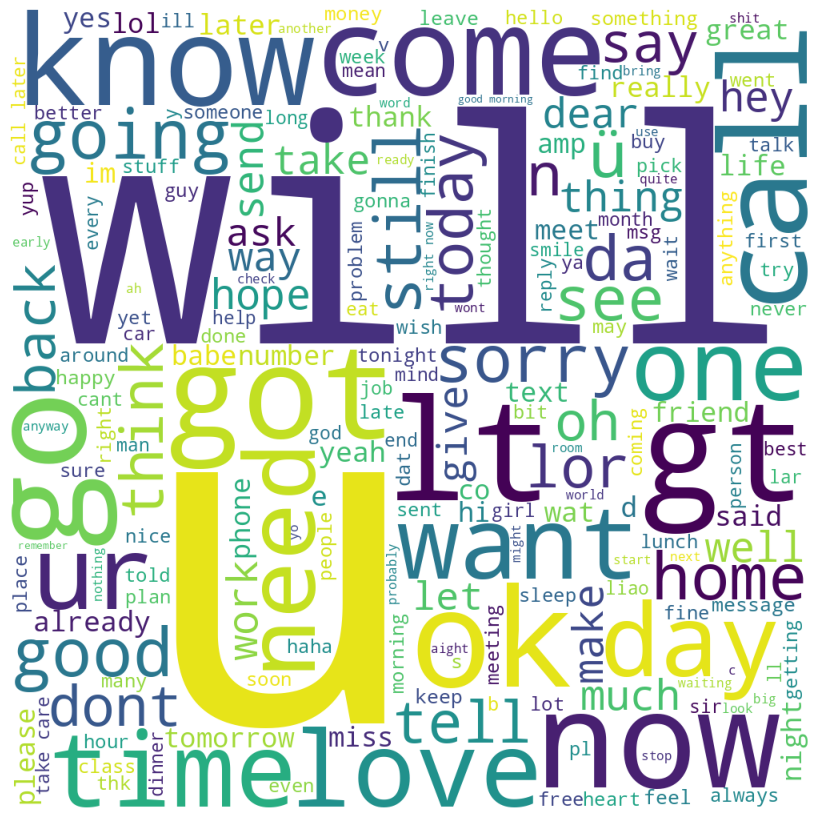

In [8]:
# visualize ham labeled sms
cloud_stopwords = set(STOPWORDS)
ham_words = collect_words(data, label="ham")

print("Total words {}".format(len(ham_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(ham_words)

# plot the WordCloud image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [9]:
# show spam messages
data[data["label"] == "spam"].sample(10)

,label,message,length,punct
879,spam,U have a secret admirer who is looking 2 make ...,132,3
3860,spam,Win the newest Harry Potter and the Order of ...,138,5
3167,spam,HOT LIVE FANTASIES call now 08707509020 Just 2...,101,3
1069,spam,Someone U know has asked our dating service 2 ...,134,3
2220,spam,You have WON a guaranteed £1000 cash or a £200...,154,2
3382,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",149,4
2850,spam,YOUR CHANCE TO BE ON A REALITY FANTASY SHOW ca...,151,3
1940,spam,More people are dogging in your area now. Call...,159,6
5141,spam,FREE for 1st week! No1 Nokia tone 4 ur mobile ...,162,7
2575,spam,Your next amazing xxx PICSFREE1 video will be ...,153,2


In [10]:
# show normal messages
data[data["label"] == "ham"].sample(10)

,label,message,length,punct
4098,ham,i am going to bed now prin,26,0
4549,ham,Hope you are having a good week. Just checking in,49,1
168,ham,"Hi frnd, which is best way to avoid missunders...",74,3
4677,ham,Ü ready then call me...,23,3
4420,ham,How have your little darlings been so far this...,122,4
1315,ham,Got but got 2 colours lor. One colour is quite...,122,5
1348,ham,She doesnt need any test.,25,1
3105,ham,That's y i said it's bad dat all e gals know u...,66,6
112,ham,Going for dinner.msg you after.,31,2
4308,ham,I guess it is useless calling u 4 something im...,54,1


In [11]:
# replace ham to 0 and spam to 1
new_data = data.replace({"ham": 0, "spam": 1})
new_data.head()

,label,message,length,punct
0,0,"Go until jurong point, crazy.. Available only ...",111,9
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,0,U dun say so early hor... U c already then say...,49,6
4,0,"Nah I don't think he goes to usf, he lives aro...",61,2


In [12]:
stop_words =  stopwords.words('english')

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"ur", " your ", text)
    text = re.sub(r" nd "," and ",text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r" tkts "," tickets ",text)
    text = re.sub(r" c "," can ",text)
    text = re.sub(r" e g ", " eg ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = re.sub(r" u "," you ",text)
    text = text.lower()  # set in lowercase

    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])

    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)

    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)

    # Return a list of words
    return(text)

In [14]:
#clean the dataset
new_data["clean_message"] = new_data["message"].apply(text_cleaning)

In [15]:
new_data["clean_message"].head()

,clean_message
0,go j ong point crazy available bugis n great w...
1,ok lar joking wif oni
2,free entry wkly comp win fa cup final ticket 2...
3,u dun say early hor u already say
4,nah think go usf life around though


In [16]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    new_data["clean_message"],
    new_data["label"],
    test_size=0.15,
    random_state=0,
    shuffle=True,
    stratify=data["label"],
)

In [17]:
# Transform text data
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)

#transform train data
X_train_trans = vectorizer.transform(X_train)

#transform test data
X_text_trans = vectorizer.transform(X_test)

In [18]:
# Create a classifier

spam_classifier = MultinomialNB()

In [19]:
# Train the model with cross validation
scores = cross_val_score(spam_classifier,X_train_trans,y_train,cv=10,verbose=3,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


In [20]:
# fine turning model parameters

distribution = {"alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0, 0.2, 0.3]}

grid = RandomizedSearchCV(
    spam_classifier,
    param_distributions=distribution,
    n_jobs=-1,
    cv=10,
    n_iter=20,
    random_state=42,
    return_train_score=True,
    verbose=2,
)

In [21]:
# training with randomized search
grid.fit(X_train_trans, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


RandomizedSearchCV(cv=10, estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [1, 0.1, 0.01, 0.001, 0.0001,
                                                  0, 0.2, 0.3]},
                   random_state=42, return_train_score=True, verbose=2)

In [22]:
# summarize the results of the random parameter search
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.9767713936539371
MultinomialNB(alpha=1)
{'alpha': 1}


In [23]:
# Train the model with best parameters

best_classifier = MultinomialNB(alpha=1)

In [24]:
#cross validation
scores = cross_val_score(best_classifier, X_train_trans, y_train, cv=10, verbose=2, n_jobs=-1)

print(scores)
print(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[0.96624473 0.97468354 0.98312236 0.98101266 0.97679325 0.98945148
 0.97040169 0.97674419 0.97463002 0.97463002]
0.9767713936539371


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


In [25]:
# train the best_classifier
best_classifier.fit(X_train_trans,y_train)

MultinomialNB(alpha=1)

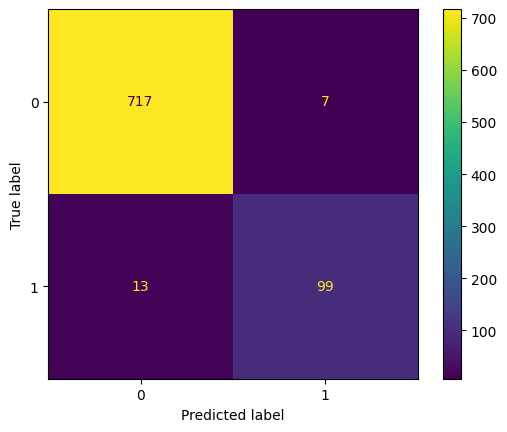

In [26]:
# Plot using ConfusingMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(best_classifier, X_text_trans, y_test, normalize=None)
plt.show()

In [27]:
# predict on the test data
y_pred = best_classifier.predict(X_text_trans)

In [28]:
# check the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       724
           1       0.93      0.88      0.91       112

    accuracy                           0.98       836
   macro avg       0.96      0.94      0.95       836
weighted avg       0.98      0.98      0.98       836

